In [1]:
from smart_open import open
import json
import supermercado
import rasterio as rio
import rioxarray
import numpy as np
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
from sklearn.cluster import KMeans
import rasterio 
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# import local modules
import sys
sys.path.insert(1, './../ds_data_generation')
from utils_raster2vector import polygonize_raster, polygonize_raster_exterior, projectShapes
from utils_vegetation import get_ndvi, filter_grassland_shrup,filter_dense_vegetation 
from utils import  save_featurecollection, get_dataArray
from utils_vector import dataset2geom, multiPolygon2polygons, get_features, set_classes_values, simplify_features
    

In [3]:
# Read coverage area
geojson_area="fixtures/reforestamos.geojson"
with open(geojson_area, "r", encoding="utf8") as f:
        feature_collection = json.load(f)["features"]
tiles = supermercado.burntiles.burn(feature_collection,14)
tiles

array([[3611, 6987,   14],
       [3612, 6987,   14],
       [3613, 6987,   14],
       [3614, 6987,   14],
       [3611, 6988,   14],
       [3612, 6988,   14],
       [3613, 6988,   14],
       [3614, 6988,   14],
       [3611, 6989,   14],
       [3612, 6989,   14],
       [3613, 6989,   14],
       [3614, 6989,   14]])

In [4]:
mosaic_ids = [
    # {"date":"2020-03_2020-06","name": "2020_spring", "mosaic_id":"30b214f3dd229a255b98d47591391e13"},
    # {"date":"2020-06_2020-09","name": "2020_summer", "mosaic_id":"3433c3eb0fb7b7526fcde72de384b4b6"},
    # {"date":"2020-09_2020-12","name": "2020_autumn", "mosaic_id":"35dcb8a0f5b040f81cae393797b4f165"},
    # {"date":"2020-12_2021-03","name": "2021_winter", "mosaic_id":"5c4077562a16cfd5a5f2131a65679094"},
    # {"date":"2021-03_2021-06","name": "2021_spring", "mosaic_id":"217af96b6f5eff81477cf0f155299ec7"},
    # {"date":"2021-06_2021-09","name": "2021_summer", "mosaic_id":"a93bf200ce915812477469fc356dcdda"},
    # {"date":"2021-09_2021-12","name": "2021_autumn", "mosaic_id":"605554a32fb193d8deb861af3b0497a7"},
    # {"date":"2021-12_2022-03","name": "2022_winter", "mosaic_id":"c9aa9a8cd6677a854e1d62a01c748871"},
    {"date":"2022-03_2022-06","name": "2022_spring", "mosaic_id":"039e234ce52b9c99c80fb4d4913a56b5"},
    # {"date":"2022-06_2022-09","name": "2022_summer", "mosaic_id":"01c43f8bcb8dafaedca16ee5f40f5d07"},
    # {"date":"2022-09_2022-12","name": "2022_autumn", "mosaic_id":"9c864f9168ca1e6367b022a09edb2410"},
    # {"date":"2022-12_2023-03","name": "2023_winter", "mosaic_id":"c329dcdf0f41e3115134fb8894932eff"},
]
# tms="https://planetarycomputer.microsoft.com/api/data/v1/mosaic/tiles/{mosaic_id}/{z}/{x}/{y}?scale=2&assets=B04&assets=B03&assets=B02&color_formula=Gamma+RGB+3.2+Saturation+0.8+Sigmoidal+RGB+25+0.35&collection=sentinel-2-l2a"
tms="https://planetarycomputer.microsoft.com/api/data/v1/mosaic/tiles/{mosaic_id}/{z}/{x}/{y}?scale=1&{assets}&collection=sentinel-2-l2a&format=tif"

In [5]:
# Load tiles in xarray
images={}
objs_arrays = {}
for mosaic in mosaic_ids:
    mosaic_id = mosaic["mosaic_id"]
    name = mosaic["name"]
    date_ = mosaic["date"]
    for tile in tiles:
        x,y,z=tile
        str_tile_name = "-".join( [str(t) for t in tile ])
        assets="assets=B02&assets=B03&assets=B04&assets=B08"
        url = tms.format(mosaic_id=mosaic_id,x=x,y=y,z=z, assets=assets)
        dataArray = get_dataArray(name,url)
        
        if dataArray is not None:
            title =  name
            # dArray = get_ndvi(dataArray)
            # dArray_= filter_dense_vegetation(dArray)
            objs_arrays[str_tile_name]=dataArray
        
list_values =list(objs_arrays.values())


In [6]:
list_values[0]


<xarray.DataArray (band: 5, y: 256, x: 256)>
[327680 values with dtype=uint16]
Coordinates:
  * band         (band) int64 1 2 3 4 5
  * x            (x) float64 -1.121e+07 -1.121e+07 ... -1.12e+07 -1.12e+07
  * y            (y) float64 2.947e+06 2.947e+06 ... 2.945e+06 2.945e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

# Clustering

In [7]:
def flat_dataArray(imagery):
    # grab the number of bands in the image, naip images have four bands
    nbands = imagery.shape[0]
    # create an empty array in which each column will hold a flattened band
    flat_data = np.empty((imagery.shape[1]*imagery.shape[2], nbands))
    # loop through each band in the image and add to the data array
    for i in range(nbands):
        band = imagery[i,:,:]
        flat_data[:, i-1] = band.values.flatten()
    return flat_data, imagery




In [8]:
# Start training the module
flat_data, imagery = flat_dataArray(list_values[0])
num_classes=3
km = KMeans(n_clusters=num_classes)
km.fit(flat_data)


/opt/conda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3)

(-0.5, 255.5, 255.5, -0.5)

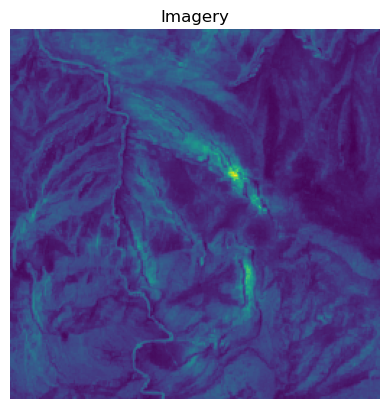

In [9]:
# use the sklearn kmeans .predict method to assign all the pixels of an image to a unique cluster
flat_predictions = km.predict(flat_data)

# rehsape the flattened precition array into an MxN prediction mask
prediction_mask = flat_predictions.reshape((imagery.shape[1], imagery.shape[2]))

#plot the imagery and the prediction mask for comparison
plt.imshow(imagery[0,:,:])
plt.title("Imagery")
plt.axis('off')
# plt.close()


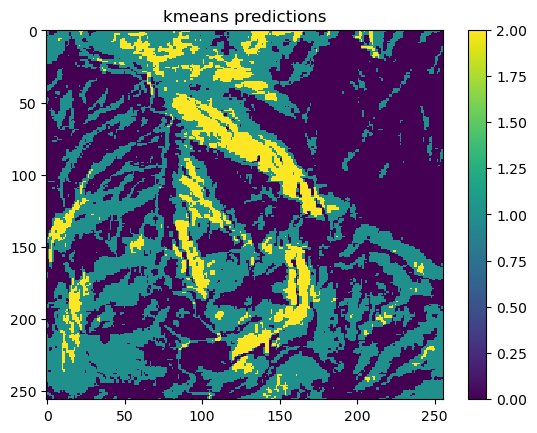

In [10]:
plt.imshow(prediction_mask,interpolation='nearest', aspect='auto')
plt.title('kmeans predictions')
plt.colorbar()
plt.show()

In [11]:
def display_multiple_img(images, rows = 1, cols=1, size=20):
    figure, ax = plt.subplots(nrows=rows,ncols=cols,figsize=(size, size) )
    for ind,title in enumerate(images):
        ax.ravel()[ind].imshow(images[title])
        ax.ravel()[ind].set_title(title)
        ax.ravel()[ind].set_axis_off()
    plt.tight_layout()
    plt.show()

In [12]:
obj_masks = {}
for key in objs_arrays.keys():
    dataArray = objs_arrays[key]
    flat_data, imagery = flat_dataArray(dataArray)
    flat_predictions = km.predict(flat_data)
    # rehsape the flattened precition array into an MxN prediction mask
    prediction_mask = flat_predictions.reshape((imagery.shape[1], imagery.shape[2]))
    obj_masks[key] = prediction_mask

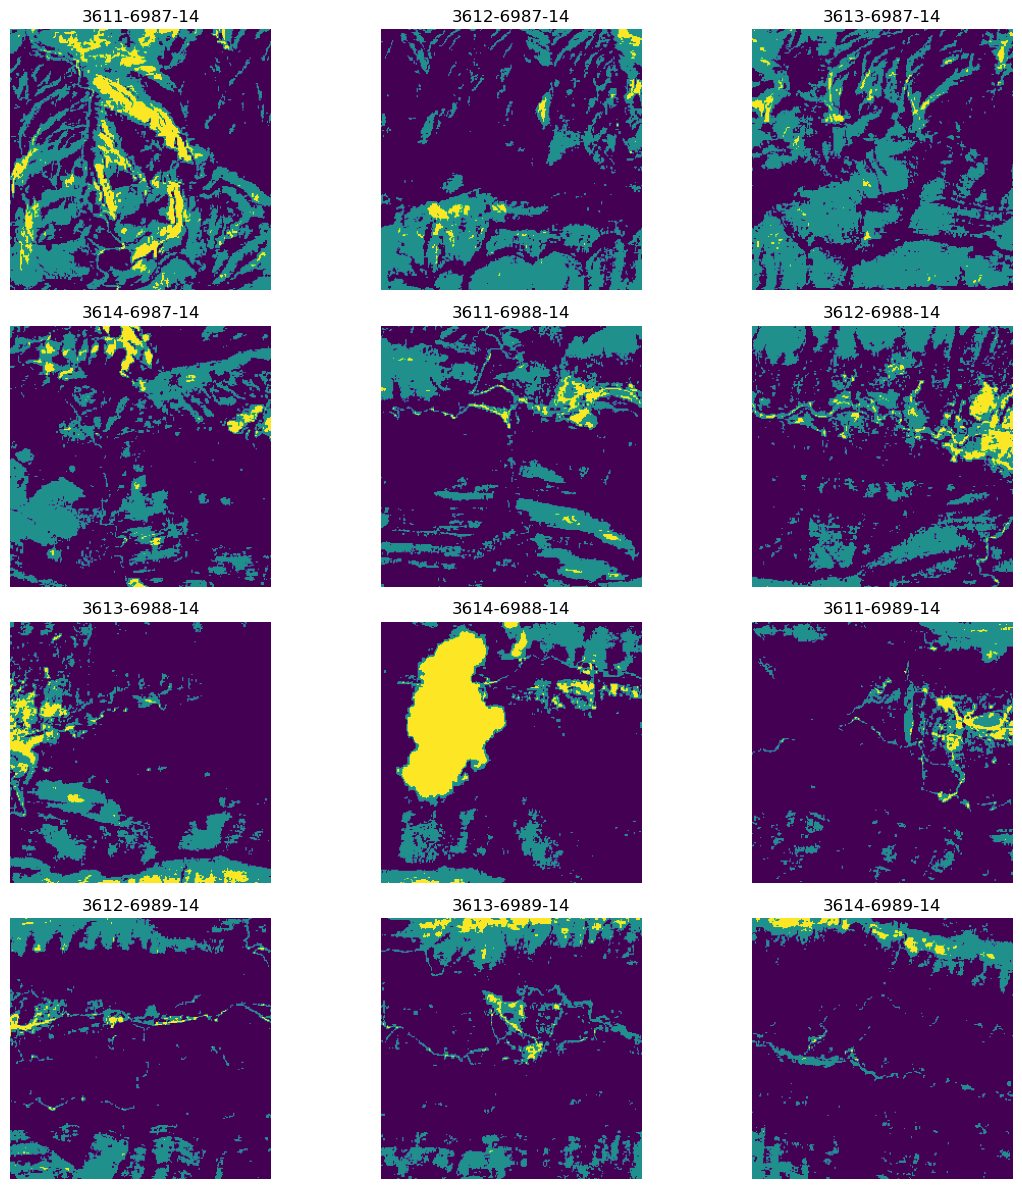

In [13]:
display_multiple_img(obj_masks, 4,3,12)

# Saving as Geojson

In [14]:
for key in obj_masks.keys():
    prediction_mask = obj_masks[key]
    dataArray = objs_arrays[key]
    # Pass geo values 
    resul_dataArray = dataArray[0]*0 + prediction_mask
    # save as tiff file
    resul_dataArray.rio.to_raster(f"data/{key}.tif")

    # Read tiff and save as geojson
    dataset = rio.open(f"data/{key}.tif")
    features_per_class = dataset2geom(dataset)
    features_per_class_simply = simplify_features(features_per_class,1,2)
    features = get_features(features_per_class_simply,1000)
    
    classes = {
        "0":"forest",
        "1": "without_apparent_vegetation",
        "2": "scrub",
        "3": "pasture"
    }
    features = set_classes_values(features, classes)
    
    save_featurecollection(features,f"data/{key}.geojson")


/tmp/ipykernel_305/2972342494.py:13: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  features = get_features(features_per_class_simply,1000)
/opt/conda/lib/python3.9/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/opt/conda/lib/python3.9/site-packages/shapely/ops.py:278: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  type(ring)(zip(*func(*zip(*ring.coords))))


Save data/3611-6987-14.geojson


/tmp/ipykernel_305/2972342494.py:13: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  features = get_features(features_per_class_simply,1000)
/opt/conda/lib/python3.9/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/opt/conda/lib/python3.9/site-packages/shapely/ops.py:278: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  type(ring)(zip(*func(*zip(*ring.coords))))


Save data/3612-6987-14.geojson


/tmp/ipykernel_305/2972342494.py:13: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  features = get_features(features_per_class_simply,1000)
/opt/conda/lib/python3.9/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/opt/conda/lib/python3.9/site-packages/shapely/ops.py:278: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  type(ring)(zip(*func(*zip(*ring.coords))))


Save data/3613-6987-14.geojson


/tmp/ipykernel_305/2972342494.py:13: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  features = get_features(features_per_class_simply,1000)
/opt/conda/lib/python3.9/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/opt/conda/lib/python3.9/site-packages/shapely/ops.py:278: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  type(ring)(zip(*func(*zip(*ring.coords))))


Save data/3614-6987-14.geojson


/tmp/ipykernel_305/2972342494.py:13: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  features = get_features(features_per_class_simply,1000)
/opt/conda/lib/python3.9/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/opt/conda/lib/python3.9/site-packages/shapely/ops.py:278: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  type(ring)(zip(*func(*zip(*ring.coords))))


Save data/3611-6988-14.geojson


/tmp/ipykernel_305/2972342494.py:13: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  features = get_features(features_per_class_simply,1000)
/opt/conda/lib/python3.9/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/opt/conda/lib/python3.9/site-packages/shapely/ops.py:278: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  type(ring)(zip(*func(*zip(*ring.coords))))


Save data/3612-6988-14.geojson


/tmp/ipykernel_305/2972342494.py:13: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  features = get_features(features_per_class_simply,1000)
/opt/conda/lib/python3.9/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/opt/conda/lib/python3.9/site-packages/shapely/ops.py:278: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  type(ring)(zip(*func(*zip(*ring.coords))))


Save data/3613-6988-14.geojson


/tmp/ipykernel_305/2972342494.py:13: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  features = get_features(features_per_class_simply,1000)
/opt/conda/lib/python3.9/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/opt/conda/lib/python3.9/site-packages/shapely/ops.py:278: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  type(ring)(zip(*func(*zip(*ring.coords))))


Save data/3614-6988-14.geojson


/tmp/ipykernel_305/2972342494.py:13: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  features = get_features(features_per_class_simply,1000)
/opt/conda/lib/python3.9/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/opt/conda/lib/python3.9/site-packages/shapely/ops.py:278: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  type(ring)(zip(*func(*zip(*ring.coords))))


Save data/3611-6989-14.geojson


/tmp/ipykernel_305/2972342494.py:13: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  features = get_features(features_per_class_simply,1000)
/opt/conda/lib/python3.9/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/opt/conda/lib/python3.9/site-packages/shapely/ops.py:278: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  type(ring)(zip(*func(*zip(*ring.coords))))


Save data/3612-6989-14.geojson


/tmp/ipykernel_305/2972342494.py:13: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  features = get_features(features_per_class_simply,1000)
/opt/conda/lib/python3.9/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/opt/conda/lib/python3.9/site-packages/shapely/ops.py:278: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  type(ring)(zip(*func(*zip(*ring.coords))))


Save data/3613-6989-14.geojson


/tmp/ipykernel_305/2972342494.py:13: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  features = get_features(features_per_class_simply,1000)
/opt/conda/lib/python3.9/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
/opt/conda/lib/python3.9/site-packages/shapely/ops.py:278: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  type(ring)(zip(*func(*zip(*ring.coords))))


Save data/3614-6989-14.geojson
